<a href="https://colab.research.google.com/github/obVdo/blood_cells_dl/blob/main/file_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install install -Uqq fastbook

     |████████████████████████████████| 720 kB 5.2 MB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 
     |████████████████████████████████| 1.2 MB 42.3 MB/s 
     |████████████████████████████████| 189 kB 36.0 MB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 
     |████████████████████████████████| 51 kB 296 kB/s 


In [17]:
import os

In [2]:
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [3]:
from fastbook import *

In [7]:
!git clone https://github.com/obVdo/blood_cells_dl

Cloning into 'blood_cells_dl'...
remote: Enumerating objects: 12550, done.
remote: Counting objects: 100% (12550/12550), done.
remote: Compressing objects: 100% (12548/12548), done.
remote: Total 12550 (delta 0), reused 12550 (delta 0), pack-reused 0
Receiving objects: 100% (12550/12550), 99.06 MiB | 31.09 MiB/s, done.
Checking out files: 100% (12518/12518), done.


In [26]:
path = Path("/content/blood_cells_dl/data/images/TRAIN")

In [27]:
fns = get_image_files(path)


In [28]:
failed = verify_images(fns)
failed

(#0) []

In [30]:
fns[0]

Path('/content/blood_cells_dl/data/images/TRAIN/LYMPHOCYTE/_2_2119.jpeg')

In [34]:
blood = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2),
    get_y = parent_label,
    item_tfms = Resize(240, ResizeMethod.Squish, pad_mode="zeros")
    
)

In [35]:
dls = blood.dataloaders(path)

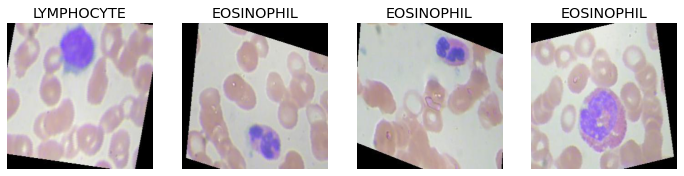

In [36]:
dls.valid.show_batch(max_n=4, nrows=1)

In [37]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [39]:
learn.fine_tune(4)


epoch,train_loss,valid_loss,error_rate,time
0,0.041180,0.078701,0.027624,03:14


epoch,train_loss,valid_loss,error_rate,time
0,0.060298,0.137978,0.037167,04:27
1,0.042424,0.007953,0.003014,04:27
2,0.009543,0.008119,0.003516,04:27
3,0.003877,0.005985,0.001005,04:27


In [40]:
interp = ClassificationInterpretation.from_learner(learn)


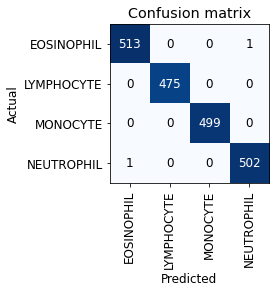

In [41]:
interp.plot_confusion_matrix()


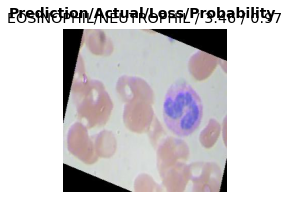

In [43]:
interp.plot_top_losses(1, nrows=1)


In [44]:
learn.export()


In [45]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [46]:
learn_inf = load_learner(path/'export.pkl')


In [47]:
learn_inf.predict("/content/blood_cells_dl/data/images/TEST/EOSINOPHIL/_0_1616.jpeg")

('EOSINOPHIL',
 TensorBase(0),
 TensorBase([5.9131e-01, 1.6766e-01, 8.2852e-06, 2.4102e-01]))

In [48]:
?learn.predict